In [1]:
import scipy.io
import numpy as np

from torch.utils.data import DataLoader
import torch
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from gwpy.timeseries import TimeSeries

import matplotlib.pyplot as plt

# Loading & Formatting the data

In [2]:
file = scipy.io.loadmat('MLdata_L1HAM5_1381528818_4000_matrix_v2.mat')
data = file['data_matrix']
data.dtype
data.shape

dic = {}
channels = ['L1:ISI-GND_STS_ITMY_X_DQ','L1:ISI-GND_STS_ITMY_Y_DQ','L1:ISI-GND_STS_ITMY_Z_DQ','L1:ISI-HAM5_SCSUM_CPS_X_IN_DQ', 'L1:ISI-HAM5_SCSUM_CPS_Y_IN_DQ', 'L1:ISI-HAM5_SCSUM_CPS_Z_IN_DQ','L1:ISI-HAM5_BLND_CPSRX_IN1_DQ', 'L1:ISI-HAM5_BLND_CPSRY_IN1_DQ', 'L1:ISI-HAM5_BLND_CPSRZ_IN1_DQ','L1:ISI-HAM5_BLND_GS13X_IN1_DQ']
#channels = ['L1:ISI-GND_STS_ITMY_X_DQ','L1:ISI-HAM5_SCSUM_CPS_X_IN_DQ', 'L1:ISI-HAM5_BLND_CPSRX_IN1_DQ', 'L1:ISI-HAM5_BLND_GS13X_IN1_DQ']
for idx,c in enumerate(channels):
    print(idx, c)
    dic[c] = data[:,idx]

0 L1:ISI-GND_STS_ITMY_X_DQ
1 L1:ISI-GND_STS_ITMY_Y_DQ
2 L1:ISI-GND_STS_ITMY_Z_DQ
3 L1:ISI-HAM5_SCSUM_CPS_X_IN_DQ
4 L1:ISI-HAM5_SCSUM_CPS_Y_IN_DQ
5 L1:ISI-HAM5_SCSUM_CPS_Z_IN_DQ
6 L1:ISI-HAM5_BLND_CPSRX_IN1_DQ
7 L1:ISI-HAM5_BLND_CPSRY_IN1_DQ
8 L1:ISI-HAM5_BLND_CPSRZ_IN1_DQ
9 L1:ISI-HAM5_BLND_GS13X_IN1_DQ


In [3]:
# skip first 100 seconds of data to be sure that everything is in a stable state
selc = {}
for c in channels:
    selc[c] = dic[c][100*128:] 

### ML specific preprocessing happens here

In [4]:
channel_list = ['L1:ISI-HAM5_BLND_GS13X_IN1_DQ', 'L1:ISI-GND_STS_ITMY_X_DQ', 'L1:ISI-GND_STS_ITMY_Y_DQ', 'L1:ISI-GND_STS_ITMY_Z_DQ', 'L1:ISI-HAM5_SCSUM_CPS_X_IN_DQ', 'L1:ISI-HAM5_SCSUM_CPS_Y_IN_DQ', 'L1:ISI-HAM5_SCSUM_CPS_Z_IN_DQ', 'L1:ISI-HAM5_BLND_CPSRX_IN1_DQ', 'L1:ISI-HAM5_BLND_CPSRY_IN1_DQ', 'L1:ISI-HAM5_BLND_CPSRZ_IN1_DQ']

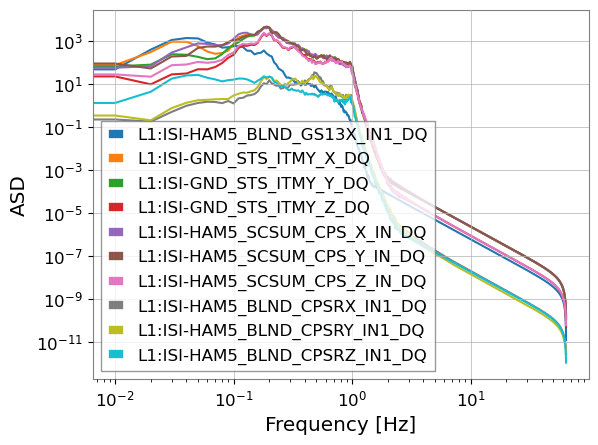

In [5]:
bandpass = True
flow = 0.03
fhigh = 1.0

for c in channel_list:
    ts = TimeSeries(selc[c], dt=1/128., t0=1381528818+100)
    if bandpass:
        ts = ts.bandpass(flow, fhigh)
        selc[c] = np.array(ts.value)
        
    ASD = ts.asd(fftlength=100,overlap=0.5,method='median')
    plt.loglog(ASD, label=c)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD')
plt.legend()

In [6]:
l = [np.transpose(selc[c]) for c in channel_list]
data_prep = np.column_stack(l)

In [7]:
# split data in train and test set
n_sec = 3000
train_frac = 0.8
val_frac = 0.2

data_prep_ = np.transpose(data_prep)
train_data = data_prep_[:, :int(128*n_sec*train_frac)]
val_data = data_prep_[:, int(128*n_sec*train_frac):int(128*n_sec)]

# normalize data for training purposes
mean = train_data.mean(axis=-1, keepdims=True)
std = train_data.std(axis=-1, keepdims=True)
train_data = (train_data - mean) / std
val_data = (val_data - mean) / std

print(train_data.shape, val_data.shape)

(10, 307200) (10, 76800)


# Training

Everything here is strongly influenced/ copied from the DeepClean setup as documented [here](https://git.ligo.org/tri.nguyen/deepclean-prod/-/tree/master?ref_type=heads)

In [17]:
class TimeSeriesSegmentDataset(Dataset):

    def __init__(self, data, kernel, stride, fs, pad_mode='median', target_idx=0):

        super().__init__()

        self.kernel = kernel
        self.stride = stride
        self.fs = fs
        self.pad_mode = pad_mode
        self.data = data
        self.target_idx = target_idx

    def __len__(self):
        """ Return the number of stride """
        nsamp = self.data.shape[-1]
        kernel = int(self.kernel * self.fs)
        stride = int(self.stride * self.fs)
        n_stride = int(np.ceil((nsamp - kernel) / stride) + 1)
        return max(0, n_stride)

    def __getitem__(self, idx):
        """ Get sample Tensor for a given index """
        # check if idx is valid:
        if idx < 0:
            idx +=  self.__len__()
        if idx >= self.__len__():
            raise IndexError(
                f'index {idx} is out of bound with size {self.__len__()}.')

        # get sample
        kernel = int(self.kernel * self.fs)
        stride = int(self.stride * self.fs)
        idx_start = idx * stride
        idx_stop = idx_start + kernel
        data = self.data[:, idx_start: idx_stop].copy()

        # apply padding if needed
        nsamp = data.shape[-1]
        if nsamp < kernel:
            pad = kernel - nsamp
            data = np.pad(data, ((0, 0), (0, pad)), mode=self.pad_mode)

        # separate into target strain and witnesses
        target = data[self.target_idx]
        target = target[:, np.newaxis]
        aux = np.delete(data, self.target_idx, axis=0)

        # convert into Tensor
        target = torch.Tensor(target)
        aux = torch.Tensor(aux)
        aux = aux.transpose(-1, -2)

        return aux, target

In [18]:
train = TimeSeriesSegmentDataset(train_data, 50.0, 1.0, 128)
train_loader = DataLoader(train, 32, num_workers=4)
valid = TimeSeriesSegmentDataset(val_data, 50.0, 1.0, 128)
val_loader = DataLoader(valid, 32, num_workers=4)

In [19]:
train_loader

# Setting-up S4D model

In [20]:
from models.s4d import S4D
import torch.nn as nn
dropout_fn = nn.Dropout2d

d_input = len(channels)-1 # number of channels (here only one time series -> 1)
d_output = 1 # number of outputs (here regression, so one output, can be several, if we want to regress several quantities)

In [26]:
# definition of SSM here
class S4Model(nn.Module):

    def __init__(
        self,
        d_input,
        d_output=10,
        d_model=256,
        n_layers=4,
        dropout=0.2,
        prenorm=False,
    ):
        super().__init__()
        self.prenorm = prenorm
        self.encoder = nn.Linear(d_input, d_model)
        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=min(0.001, 0.01))
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))
        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)
        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)
            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)
            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)
            # Dropout on the output of the S4 block
            z = dropout(z)
            # Residual connection
            x = z + x
            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)
        x = x.transpose(-1, -2)
        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)
        
        return x

In [27]:
# Model
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('==> Building model..')
model = S4Model(d_input=d_input, d_output=d_output, d_model=4, n_layers=2, dropout=0.0, prenorm=False)
model = model.to(device)
print('...done!')

==> Building model..
...done!


In [28]:
import torch.optim as optim
def setup_optimizer(model, lr, weight_decay, epochs):
    all_parameters = list(model.parameters())
    params = [p for p in all_parameters if not hasattr(p, "_optim")]
    optimizer = optim.AdamW(params, lr=lr, weight_decay=weight_decay)
    hps = [getattr(p, "_optim") for p in all_parameters if hasattr(p, "_optim")]
    hps = [
        dict(s) for s in sorted(list(dict.fromkeys(frozenset(hp.items()) for hp in hps)))
    ]  # Unique dicts
    for hp in hps:
        params = [p for p in all_parameters if getattr(p, "_optim", None) == hp]
        optimizer.add_param_group(
            {"params": params, **hp}
        )

    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    keys = sorted(set([k for hp in hps for k in hp.keys()]))
    for i, g in enumerate(optimizer.param_groups):
        group_hps = {k: g.get(k, None) for k in keys}
        print(' | '.join([
            f"Optimizer group {i}",
            f"{len(g['params'])} tensors",
        ] + [f"{k} {v}" for k, v in group_hps.items()]))

    return optimizer, scheduler

criterion = nn.MSELoss()
optimizer, scheduler = setup_optimizer(model, lr=0.01, weight_decay=0.01, epochs=10)

Optimizer group 0 | 16 tensors | lr 0.01 | weight_decay 0.01
Optimizer group 1 | 6 tensors | lr 0.001 | weight_decay 0.0


## Actual training

In [29]:
best_loss = np.inf  # best test loss
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
doc_loss = []
doc_val = []

In [31]:
import os

# Training
from tqdm.auto import tqdm
def train():
    model.train()
    train_loss = 0
    pbar = tqdm(enumerate(train_loader))
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        pbar.set_description(
            'Batch Idx: (%d/%d) | Loss: %.3f ' %
            (batch_idx, len(train_loader), train_loss/(batch_idx+1))
        )
        doc_loss.append(train_loss/(batch_idx+1))

def eval(epoch, dataloader, checkpoint=False):
    global best_loss
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        pbar = tqdm(enumerate(dataloader))
        for batch_idx, (inputs, targets) in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            eval_loss += loss.item()
            pbar.set_description(
                'Batch Idx: (%d/%d) | Loss: %.3f' %
                (batch_idx, len(dataloader), eval_loss/(batch_idx+1))
            )
            doc_val.append(eval_loss/(batch_idx+1))

    # Save checkpoint.
    if checkpoint:
        if loss < best_loss:
            state = {
                'model': model.state_dict(),
                'loss': loss,
                'epoch': epoch,
            }
            if not os.path.isdir('checkpoint'):
                os.mkdir('checkpoint')
            torch.save(state, './checkpoint/ckpt.pth')
            best_loss = loss
        

        return loss

pbar = tqdm(range(start_epoch, 50))
for epoch in pbar:
    if epoch == 0:
        pbar.set_description('Epoch: %d' % (epoch))
    else:
        pbar.set_description('Epoch: %d | Val loss: %1.3f' % (epoch, val_loss))
    train()
    val_loss = eval(epoch, val_loader, checkpoint=True)
    #eval(epoch, test_loader)
    scheduler.step()

Epoch: 0:   0%|          | 0/50 [00:00<?, ?it/s]
0it [00:00, ?it/s]
Batch Idx: (0/74) | Loss: 0.482 : : 0it [00:00, ?it/s]
Batch Idx: (0/74) | Loss: 0.482 : : 1it [00:00,  1.35it/s]
Batch Idx: (1/74) | Loss: 0.427 : : 1it [00:00,  1.35it/s]
Batch Idx: (2/74) | Loss: 0.428 : : 1it [00:00,  1.35it/s]
Batch Idx: (3/74) | Loss: 0.424 : : 1it [00:00,  1.35it/s]
Batch Idx: (4/74) | Loss: 0.455 : : 1it [00:00,  1.35it/s]
Batch Idx: (5/74) | Loss: 0.507 : : 1it [00:00,  1.35it/s]
Batch Idx: (6/74) | Loss: 0.503 : : 1it [00:00,  1.35it/s]
Batch Idx: (7/74) | Loss: 0.492 : : 1it [00:00,  1.35it/s]
Batch Idx: (8/74) | Loss: 0.518 : : 1it [00:00,  1.35it/s]
Batch Idx: (8/74) | Loss: 0.518 : : 9it [00:00, 13.85it/s]
Batch Idx: (9/74) | Loss: 0.571 : : 9it [00:00, 13.85it/s]
Batch Idx: (10/74) | Loss: 0.672 : : 9it [00:00, 13.85it/s]
Batch Idx: (11/74) | Loss: 0.727 : : 9it [00:00, 13.85it/s]
Batch Idx: (12/74) | Loss: 0.702 : : 9it [00:00, 13.85it/s]
Batch Idx: (13/74) | Loss: 0.702 : : 9it [00:00,

### Plotting and diagnostics of training

Text(0, 0.5, 'MSE loss value')

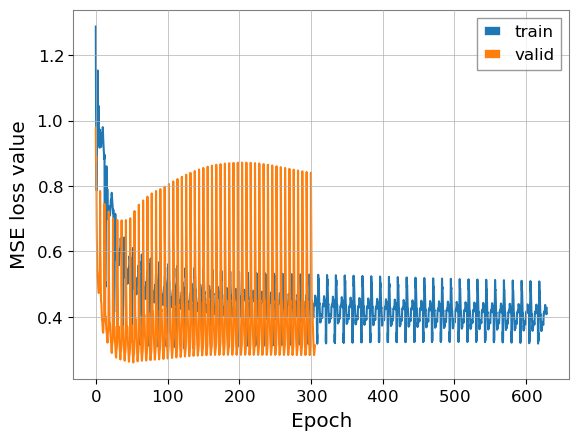

In [33]:
plt.plot(np.arange(0,len(doc_loss)/6.,1/6.), doc_loss, label='train')
plt.plot(np.arange(0, len(doc_val)/3., 1./3.), doc_val, label='valid')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE loss value')

# Inference

In [34]:
# run inference
pred_batches = eval(val_loader, model, device=device)
# postprocessing the ouput ('glue' together the individual predictions)
noverlap = int((50.0 - 1.0) * 128)
pred = dc.signal.overlap_add(pred_batches, noverlap, 'hanning')

# convert back to unit of target
pred *= std[0].ravel()
pred += mean[0].ravel()

true = val_data[0]*std[0].ravel() 
true += mean[0].ravel()

NameError: name 'dc' is not defined